# task 5: Autoencoder for Anomaly Detection

# Task

Implement a Quantum Machine Learning model to detect defective production part. The implementation includes the preprocessing of the 
data, the implementation of a model and the visualization of the results. In this notebook you will see our attempt to do Anomaly Detection using QAE

## Imports and Install

In [1]:
!pip install pennylane
!git clone https://github.com/VoicuTomut/Enhanced-Autoencoders-for-anomaly-detection.git

import sys
sys.path.append('/content/Enhanced-Autoencoders-for-anomaly-detection')
sys.path.append('/content/Enhanced-Autoencoders-for-anomaly-detection/qencode')


fatal: destination path 'Enhanced-Autoencoders-for-anomaly-detection' already exists and is not an empty directory.


## Imports

In [2]:
import os
from sklearn import datasets
import pandas as pd
import pennylane.numpy as np
import pennylane as qml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

## Google Drive Mounting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_path = '/content/drive/MyDrive/NEW_DATASET_CROP_10_Binary_NEW'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

## Data Pre-Processing (Initial was done in another notebook)

In [6]:
def load_images(path, label):
    images = []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = imread(img_path, as_gray=True)
        img = resize(img, (32, 32), anti_aliasing=True)
        images.append(img.flatten())
    return np.array(images)

X = load_images(os.path.join(train_path, '0'), 0)
Y = np.ones(len(X))
data_illegal = load_images(os.path.join(train_path, '1'), 1)
y_illegal = np.ones(len(data_illegal))

X = X / X.max()
data_illegal = data_illegal / data_illegal.max()

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, stratify=Y, random_state=seed
)

X_train, X_test, y_train, y_test, data_illegal, y_illegal = map(
    jnp.array, [X_train, X_test, y_train, y_test, data_illegal, y_illegal]
)


## Main code 

### Params

In [ ]:
seed = 10254
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
# Parameters
num_trash_bits = 5
num_data_bits = 5
num_entangler_bits = 2
num_layers = 2
batch = 5
epochs = 200
lr = 0.01

num_wires = num_trash_bits + num_data_bits
trash_bits_encoding = list(range(num_trash_bits))
data_bits_encoding = list(range(num_trash_bits, num_wires))
entangler_bits_encoding = list(range(num_wires, num_wires + num_entangler_bits))


num_weights = (
    num_layers * (num_wires + num_entangler_bits // 2) * 2 * 2 + num_trash_bits * 2
)

weights_encoder = jax.random.uniform(key, (num_weights,), minval=-np.pi, maxval=np.pi)
weights_decoder = jax.random.uniform(key, (num_weights,), minval=-np.pi, maxval=np.pi)

## Ansatz and Quantum Circuits

In [ ]:
# Our ansatz which is used 
def layer(theta, x, trash, data, entangler, pattern):
    qml.broadcast(
        qml.RY,
        wires=trash + data + entangler,
        pattern="single",
        parameters=jnp.array(
            [
                theta[0][j] * x[i] + theta[0][j + 1]
                for i, j in zip(
                    range(num_wires + num_entangler_bits // 2),
                    range(0, 2 * (num_wires + num_entangler_bits // 2), 2),
                )
            ]
        ),
    )
    qml.broadcast(qml.CZ, wires=trash, pattern="all_to_all")
    qml.broadcast(qml.CZ, wires=trash + data + entangler, pattern=pattern[0])
    qml.broadcast(
        qml.RY,
        wires=trash + data + entangler,
        pattern="single",
        parameters=jnp.array(
            [
                theta[1][j] * x[i] + theta[1][j + 1]
                for i, j in zip(
                    range(num_wires + num_entangler_bits // 2),
                    range(0, 2 * (num_wires + num_entangler_bits // 2), 2),
                )
            ]
        ),
    )
    qml.broadcast(qml.CZ, wires=trash, pattern="all_to_all")
    qml.broadcast(qml.CZ, wires=trash + data + entangler, pattern=pattern[1])

def make_entangled_bits(entangler):
    for i, j in zip(entangler[::2], entangler[1::2]):
        qml.Hadamard(i)
        qml.CNOT(wires=[i, j])

def get_pattern(trash, data):
    pattern = []
    for i in trash:
        for j in data:
            if i < j:
                pattern.append([i, j])
    pattern0 = pattern[: len(pattern) // 2]
    pattern1 = pattern[len(pattern) // 2:]
    new = []
    for i, j in zip(pattern1[::2], pattern1[1::2]):
        new.extend([j, i])
    pattern0_ = []
    for i, j in zip(pattern0[::2], new[::2]):
        pattern0_.extend([i, j])
    pattern1_ = []
    for i, j in zip(pattern0[1::2], new[1::2]):
        pattern1_.extend([i, j])
    if len(pattern0) % 2 != 0:
        pattern0_.append(pattern0[-1])
    if len(pattern1) % 2 != 0:
        pattern1_.append(pattern1[-1])
    pattern = [pattern0_, pattern1_]
    return pattern

#Function that encodes the Layer for number of layers time
def U(theta0, x, trash, data, entangler, pattern):
    for l in range(num_layers):
        layer(theta0[l], x, trash, data, entangler, pattern)

def iterate_batches(X, Y, batch_size):
    global key
    key, subkey = jax.random.split(key)
    indices = jax.random.permutation(subkey, len(X))
    X, Y = X[indices], Y[indices]
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

@jax.jit
@qml.qnode(dev0, interface="jax")
def circuit_encoding(params, x, state):
    x = jnp.array([x] * num_wires)
    theta0 = params[: -num_trash_bits * 2].reshape(num_layers, 2, -1)
    theta1 = params[-num_trash_bits * 2:].reshape(1, -1)

    qml.AmplitudeEmbedding(state, wires=range(num_wires), normalize=True)

    make_entangled_bits(entangler_bits_encoding)

    U(
        theta0,
        x,
        trash_bits_encoding,
        data_bits_encoding,
        entangler_bits_encoding[::2],
        pattern_encode_0,
    )

    qml.broadcast(
        qml.RY,
        wires=range(num_trash_bits),
        pattern="single",
        parameters=jnp.array(
            [
                theta1[0][j] * x[i] + theta1[0][j + 1]
                for i, j in zip(range(num_trash_bits), range(0, 2 * num_trash_bits, 2))
            ]
        ),
    )
    return qml.density_matrix(wires=range(num_trash_bits))

def encoding_fidelity(params, x, state):
    trash = circuit_encoding(params, x, state)
    fid = jnp.dot(jnp.conj(zero_state), jnp.dot(trash, zero_state))
    return jnp.real(fid)

def cost_encoding(params, X, Y):
    return -jnp.mean(jax.vmap(encoding_fidelity, in_axes=[None, 0, 0])(params, Y, X))

def encoding_fidelity(params, x, state):
    trash = circuit_encoding(params, x, state)
    fid = jnp.dot(jnp.conj(zero_state), jnp.dot(trash, zero_state))
    return jnp.real(fid)

def cost_encoding(params, X, Y):
    return -jnp.mean(jax.vmap(encoding_fidelity, in_axes=[None, 0, 0])(params, Y, X))


Training encoder...


/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Epoch 0: encoder loss = -0.932154655456543
Epoch 5: encoder loss = -0.9653419256210327
Epoch 10: encoder loss = -0.9328516125679016
Epoch 15: encoder loss = -0.9497559070587158
Epoch 20: encoder loss = -0.9512365460395813
Epoch 25: encoder loss = -0.9573947191238403
Epoch 30: encoder loss = -0.940866231918335
Epoch 35: encoder loss = -0.9578104019165039
Epoch 40: encoder loss = -0.957040548324585
Epoch 45: encoder loss = -0.9433009624481201
Epoch 50: encoder loss = -0.934539258480072
Epoch 55: encoder loss = -0.9229391813278198
Epoch 60: encoder loss = -0.9538595080375671
Epoch 65: encoder loss = -0.9581329822540283
Epoch 70: encoder loss = -0.9465159773826599
Epoch 75: encoder loss = -0.9540733098983765
Epoch 80: encoder loss = -0.9485855102539062
Epoch 85: encoder loss = -0.9481195211410522
Epoch 90: encoder loss = -0.9424183368682861
Epoch 95: encoder loss = -0.9505499601364136
Epoch 100: encoder loss = -0.9403215050697327
Epoch 105: encoder loss = -0.9345926642417908
Epoch 110: enc

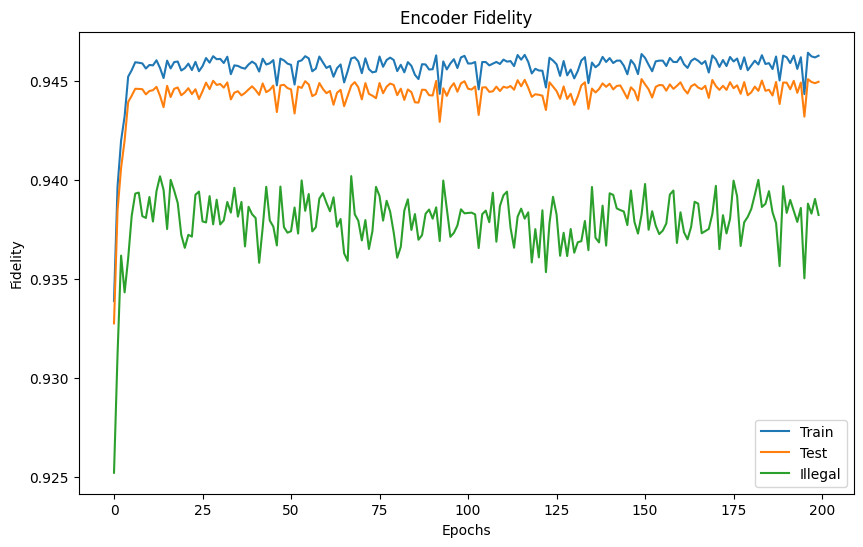

In [ ]:
pattern_encode_0 = get_pattern(
    trash_bits_encoding, data_bits_encoding + entangler_bits_encoding[::2]
)

dev0 = qml.device("default.qubit", wires=num_wires + num_entangler_bits, shots=None)
zero_state = jnp.zeros(2 ** num_trash_bits)
zero_state = zero_state.at[0].set(1)

train_fid_hist = []
test_fid_hist = []
illegal_fid = []

# Function that trains encoder
def fit_encoder(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, X, Y):
        loss_value, grads = jax.value_and_grad(cost_encoding)(params, X, Y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(epochs):
        for x_batch, y_batch in iterate_batches(X_train, y_train, batch):
            params, opt_state, loss_value = step(params, opt_state, x_batch, y_batch)

        train_fid_hist.append(-cost_encoding(params, X_train, y_train))
        test_fid_hist.append(-cost_encoding(params, X_test, y_test))
        illegal_fid.append(-cost_encoding(params, data_illegal, y_illegal))

        if i % 5 == 0:
            print(f"Epoch {i}: encoder loss = {loss_value}")

    return params


# Code to train encoder
print("Training encoder...")
optimizer = optax.adam(lr)
t1 = time.time()
weights_encoder = fit_encoder(weights_encoder, optimizer)
print(f"Encoder training time: {time.time() - t1} seconds")

plt.figure(figsize=(10, 6))
plt.plot(train_fid_hist, label="Train")
plt.plot(test_fid_hist, label="Test")
plt.plot(illegal_fid, label="Illegal")
plt.legend()
plt.title("Encoder Fidelity")
plt.xlabel("Epochs")
plt.ylabel("Fidelity")
plt.show()

## Results and Metrics

Train Accuracy: 0.4672544002532959
Test Accuracy: 0.43988269567489624
Illegal Data Accuracy: 0.5232273936271667


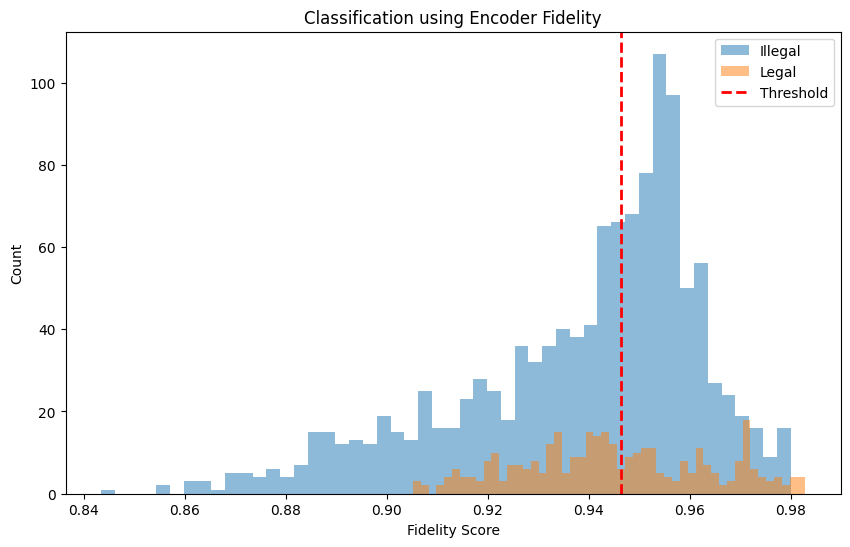

Parameters:
Trash Bits: 5
Data Bits: 5
EPR Pairs: 1
Layers: 2
Training Epochs: 200
Batch Size: 5
Learning Rate: 0.01


In [16]:
def get_fid_scores(params, X, Y):
    return jax.vmap(encoding_fidelity, in_axes=[None, 0, 0])(params, Y, X)

def classify(params, X, Y, threshold):
    fid_scores = get_fid_scores(params, X, Y)
    return (fid_scores > threshold).astype(int)

fid_scores_train = get_fid_scores(weights_encoder, X_train, y_train)
fid_scores_test = get_fid_scores(weights_encoder, X_test, y_test)
fid_scores_illegal = get_fid_scores(weights_encoder, data_illegal, y_illegal)

optimal_threshold = np.mean(fid_scores_train)

y_pred_train = classify(weights_encoder, X_train, y_train, optimal_threshold)
y_pred_test = classify(weights_encoder, X_test, y_test, optimal_threshold)
y_pred_illegal = classify(weights_encoder, data_illegal, y_illegal, optimal_threshold)

train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
illegal_accuracy = np.mean(y_pred_illegal != y_illegal)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Illegal Data Accuracy: {illegal_accuracy}")

plt.figure(figsize=(10, 6))
plt.hist(fid_scores_illegal, bins=50, alpha=0.5, label='Illegal')
plt.hist(fid_scores_test, bins=50, alpha=0.5, label='Legal')
plt.axvline(optimal_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.title("Classification using Encoder Fidelity")
plt.xlabel("Fidelity Score")
plt.ylabel("Count")
plt.legend()
plt.show()

print("Parameters:")
for key, value in PARAMETERS.items():
    print(f"{key}: {value}")

For task 5 We've experimented with quantum autoencoder, and did anomaly detection using fidelity scores. Although classical autoencoder perform very good on such tasks, and quantum model was able to distinguish between zero and one on digits dataset, we were not able to make it work on our dataset. Model failed to distinguish between anomaly, and non-anomaly. They have almost identical scores. Different experiments with trash data, and EPR bits didn't result in new changes. We were not able to train the decoder part too. A further study is required comparing different anzatses, and techniques. Some authors including D-WAVE have claimed that they've achieved good results with auto-encoders.